# MRIO Workshop

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Data

In [4]:
var_list = ['Z', 'V', 'Y', 'F_NRG', 'F_NRG_hh', 'F_GHG', 'F_GHG_hh']
Z, V, Y, F_NRG, F_NRG_hh, F_GHG, F_GHG_hh, year_list = [], [], [], [], [], [], [], []

for var in var_list:
    for year in range(1995, 2010):
        if year not in year_list:
            year_list.append(year)
        if var.split('_')[0] == 'F' and var.split('_')[-1] != 'hh':
            my_col = 0
        else:
             my_col = [0, 1]
        if var.split('_')[-1] == 'hh':
            my_header = 0
        else:
            my_header = [0, 1]
            
        df = pd.read_csv('Data/clean_data/' + var + '_' + str(year) + '.csv', header=my_header, index_col=my_col).dropna(how='all', axis=0)
        eval(var).append(df)
        
# ensure that indecies match up

new_names = {'ROM':'ROU', 'RoW':'ROW', 'c1':'c01', 'c2':'c02', 'c3':'c03', 'c4':'c04', 'c5':'c05', 'c6':'c06', 'c7':'c07', 'c8':'c08', 'c9':'c09'}
for i in range(len(year_list)):
    Y[i] = Y[i].rename(columns=new_names, index=new_names).swaplevel(axis=1)
    Y[i] = Y[i].reindex(sorted(Y[i].columns), axis=1).reindex(sorted(Y[i].index), axis=0)
    
    Z[i] = Z[i].rename(columns=new_names, index=new_names)
    Z[i] = Z[i].reindex(sorted(Z[i].columns), axis=1).reindex(sorted(Z[i].index), axis=0)
    
    V[i] = V[i].rename(columns=new_names, index=new_names)
    V[i] = V[i].reindex(sorted(V[i].columns), axis=1).reindex(sorted(V[i].index), axis=0)
    
    F_NRG[i] = F_NRG[i].rename(columns=new_names, index=new_names)
    F_NRG[i] = F_NRG[i].reindex(sorted(F_NRG[i].columns), axis=1)
    F_GHG[i] = F_GHG[i].rename(columns=new_names, index=new_names)
    F_GHG[i] = F_GHG[i].reindex(sorted(F_GHG[i].columns), axis=1)
    
    F_NRG_hh[i] = F_NRG_hh[i].reindex(Y[i].index.levels[0], axis=1)
    F_GHG_hh[i] = F_GHG_hh[i].reindex(Y[i].index.levels[0], axis=1)

# 5. Calculating energy and emissions consumption-based accounts

For reference, use:  
http://www.see.leeds.ac.uk/teaching-resources/exercise-pages/l4-input-output-tutorial-201617/  
http://mathesaurus.sourceforge.net/matlab-numpy.html 

### 5.1. The UK's production and consumption based GHG emissions from 1995-2009

In [5]:
UK_consumption = []
UK_production = []
for i in range(len(year_list)):
    # territorial emissions
    UK_prod = float(F_GHG[i]['GBR'].sum(axis=1)) + float(F_GHG_hh[i]['GBR'])
    UK_production.append(UK_prod)

    # consumption based emissions
    x = np.array(Y[i].sum(axis=1) + Z[i].sum(axis=1))
    for j in range(len(x)):
        if x[j]==0:
            x[j]=0.000000001 # do this to avoid trying to divide my zero later
        else:
            pass
    x = x.reshape(1435,1)
    big_x = x.repeat(len(x), axis=1)
    x_t = np.matrix.transpose(big_x)
    
    A = np.array(Z[i]) / x_t
    I = np.identity(len(Z[i]))
    L = np.linalg.inv(I-A)
    F_GHGx = np.array(F_GHG[i]) / (x.reshape(1, 1435))
    
    Y_UK = np.array(Y[i][['GBR']]).sum(axis=1).reshape(1435, 1)

    temp = np.matmul(F_GHGx, L)
    temp = np.matmul(temp, Y_UK)
    
    UK_cons = temp + float(F_GHG_hh[i]['GBR'])
    UK_consumption.append(UK_cons[0][0])

In [6]:
UK_co2e = pd.DataFrame()
UK_co2e['Consumption'] = UK_consumption
UK_co2e['Production'] = UK_production
UK_co2e['Year'] = year_list

Text(0.5,1,'UK')

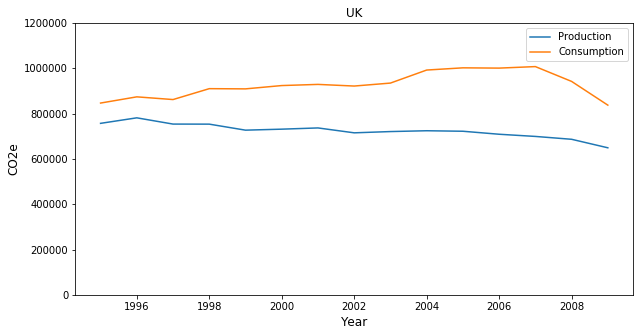

In [7]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

UK_co2e.plot(ax=ax, x='Year', y='Production')
UK_co2e.plot(ax=ax, x='Year', y='Consumption')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('CO2e', fontsize=12)
ax.set_ylim([0,1200000])
ax.set_title('UK')

### 5.2. What proportion of the Global total is the production and consumption energy account of the BRIC countries (Brazil, Russia, India & China) for the years 1995-2009?

In [8]:
BRIC_countries = ['BRA', 'RUS', 'IND', 'CHN']
country_list = F_NRG_hh[0].columns.tolist()

BRIC_consumption = []
BRIC_production = []
for i in range(len(year_list)):
    # territorial emissions
    BRIC_prod = float(F_NRG[i][BRIC_countries].sum(axis=1)) + float(F_NRG_hh[i][BRIC_countries].sum(axis=1))
    global_prod = float(F_NRG[i].sum(axis=1)) + float(F_NRG_hh[i].sum(axis=1))
    BRIC_production.append(BRIC_prod/global_prod * 100)

    # consumption based emissions
    x = np.array(Y[i].sum(axis=1) + Z[i].sum(axis=1))
    for j in range(len(x)):
        if x[j]==0:
            x[j]=0.000000001 # do this to avoid trying to divide my zero later
        else:
            pass
    x = x.reshape(1435,1)
    big_x = x.repeat(len(x), axis=1)
    x_t = np.matrix.transpose(big_x)
    
    A = np.array(Z[i]) / x_t
    I = np.identity(len(Z[i]))
    L = np.linalg.inv(I-A)
    F_NRGx = np.array(F_NRG[i]) / (x.reshape(1, 1435))
    
    temp_1 = np.matmul(F_NRGx, L)
    
    BRIC_cons = 0
    global_cons = 0
    for c in country_list:
        Y_temp = np.array(Y[i][[c]]).sum(axis=1).reshape(1435, 1)
        temp_2 = np.matmul(temp_1, Y_temp)
        cons = temp_2 + float(F_NRG_hh[i][[c]].sum(axis=1))
        global_cons += cons[0][0]
        if c in BRIC_countries:
            BRIC_cons += cons[0][0]
        
    BRIC_consumption.append(BRIC_cons/global_cons * 100)

In [9]:
BRIC_energy = pd.DataFrame()
BRIC_energy['Consumption'] = BRIC_consumption
BRIC_energy['Production'] = BRIC_production
BRIC_energy['Year'] = year_list

Text(0.5,1,'BRIC Countries')

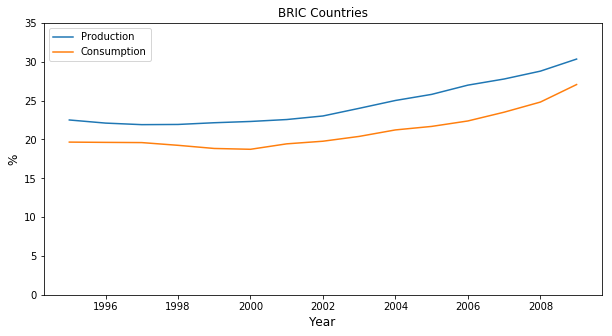

In [10]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

BRIC_energy.plot(ax=ax, x='Year', y='Production')
BRIC_energy.plot(ax=ax, x='Year', y='Consumption')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('%', fontsize=12)
ax.set_ylim([0,35])
ax.set_title('BRIC Countries')

### 5.3. What proportion of the UK’s GHG footprint is sourced from BRIC nations?

In [11]:
BRIC_countries = ['BRA', 'RUS', 'IND', 'CHN']
UK_BRIC = []
sectors = 35

for i in range(len(year_list)):
    x = np.array(Z[i].sum(axis=1) + Y[i].sum(axis=1))
    for j in range(len(x)):
        if x[j]==0:
            x[j]=0.000000001 # do this to avoid trying to divide my zero later
        else:
            pass
    x = x.reshape(1435,1)
    big_x = x.repeat(len(x), axis=1)
    x_t = np.matrix.transpose(big_x)
    
    A = np.array(Z[i]) / x_t
    I = np.identity(len(Z[i]))
    L = np.linalg.inv(I-A)
    F_GHGx = np.array(F_GHG[i]) / (x.reshape(1, 1435))
    
    Y_UK = np.array(Y[i][['GBR']]).sum(axis=1).reshape(1435, 1)

    temp = np.matmul(np.diag(F_GHGx[0]), L)
    temp = np.matmul(temp, np.diag(Y_UK.reshape(1, 1435)[0]))
    temp = pd.DataFrame(temp, index=Z[0].index, columns=Z[0].columns) # change back into df to more easily extract the countries
    
    BRIC_value = 0
    for c in BRIC_countries:
        temp_1 = temp.T[c].sum().sum()
        BRIC_value += temp_1
    
    UK_BRIC.append(BRIC_value/UK_consumption[i] * 100)   

In [12]:
UK_BRIC_ghg = pd.DataFrame()
UK_BRIC_ghg['BRIC_prop'] = UK_BRIC
UK_BRIC_ghg['Year'] = year_list

Text(0.5,1,'UK GHG - BRIC Proportion')

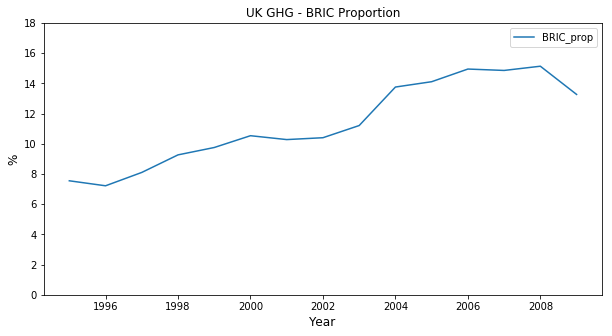

In [13]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

UK_BRIC_ghg.plot(ax=ax, x='Year', y='BRIC_prop')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('%', fontsize=12)
ax.set_ylim([0,18])
ax.set_title('UK GHG - BRIC Proportion')

### 5.4. What proportion of UK’s GHG footprint can be shown to originate from the agricultural industry?

In [14]:
UK_agriculture = []

for i in range(len(year_list)):
    x = np.array(Y[i].sum(axis=1) + Z[i].sum(axis=1))
    for j in range(len(x)):
        if x[j]==0:
            x[j]=0.000000001 # do this to avoid trying to divide my zero later
        else:
            pass
    x = x.reshape(1435,1)
    big_x = x.repeat(len(x), axis=1)
    x_t = np.matrix.transpose(big_x)
    
    A = np.array(Z[i]) / x_t
    I = np.identity(len(Z[i]))
    L = np.linalg.inv(I-A)
    F_GHGx = np.array(F_GHG[i]) / (x.reshape(1, 1435))
    
    Y_UK = np.array(Y[i][['GBR']]).sum(axis=1).reshape(1435, 1)

    temp = np.matmul(np.diag(F_GHGx[0]), L)
    temp = np.matmul(temp, np.diag(Y_UK.reshape(1, 1435)[0]))
    temp = pd.DataFrame(temp, index=Z[0].index, columns=Z[0].columns) # change back into df to more easily extract the countries
    
    agri_value = temp.T.swaplevel(axis=1)['c01'].sum().sum()
    
    UK_agriculture.append(agri_value/UK_consumption[i] * 100)   

In [15]:
UK_agri_ghg = pd.DataFrame()
UK_agri_ghg['agri_prop'] = UK_agriculture
UK_agri_ghg['Year'] = year_list

Text(0.5,1,'UK GHG - Agriculture Proportion')

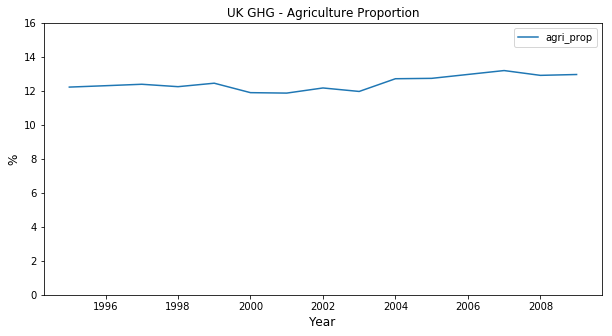

In [16]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

UK_agri_ghg.plot(ax=ax, x='Year', y='agri_prop')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('%', fontsize=12)
ax.set_ylim([0,16])
ax.set_title('UK GHG - Agriculture Proportion')

In [17]:
# above answer is off by about 1% for each year .. 

### 6.1. Make Y_G8 a ‘1 x 1435’ vector showing the final demand of the G8 nations and use this to find the total energy footprint of G8 nations 

In [18]:
G8 = ['CAN','DEU','FRA','GBR','ITA','JPN','RUS','USA']
country = Y[0].columns.levels[0].tolist()
regions = len(country)
final_demand = len(Y[0].columns.levels[1].tolist())
G8_Y_agg = np.zeros((regions*final_demand, 1))
G8_lookup = np.zeros((regions,1))

for i in range(len(country)):
    if country[i] in G8:
        G8_lookup[i] = 1
        
for i in range(len(G8_lookup)):
    j = i+1 # because indexing starts at 0 in python
    if G8_lookup[i] == 1:
        G8_Y_agg[(j*final_demand)-final_demand:j*final_demand] = np.ones((final_demand,1))

In [19]:
G8_energy_cons = []

for i in range(len(year_list)):
    x = np.array(Y[i].sum(axis=1) + Z[i].sum(axis=1))
    for j in range(len(x)):
        if x[j]==0:
            x[j]=0.000000001 # do this to avoid trying to divide my zero later
        else:
            pass
    x = x.reshape(1435,1)
    big_x = x.repeat(len(x), axis=1)
    x_t = np.matrix.transpose(big_x)
    
    A = np.array(Z[i]) / x_t
    I = np.identity(len(Z[i]))
    L = np.linalg.inv(I-A)
    F_NRGx = np.array(F_NRG[i]) / (x.reshape(1, 1435))
    
    Y_G8 = np.matmul(np.array(Y[i]),  G8_Y_agg)
    
    temp = np.matmul(F_NRGx, L)
    temp = np.matmul(temp, Y_G8)
    
    temp_1 = np.matmul(np.array(F_NRG_hh[i]), G8_lookup)
    
    G8_cons = temp[0][0] + temp_1[0][0]
    
    G8_energy_cons.append(G8_cons)

In [20]:
G8_cons_nrg = pd.DataFrame()
G8_cons_nrg['G8'] = G8_energy_cons
G8_cons_nrg['Year'] = year_list

Text(0.5,1,'G8')

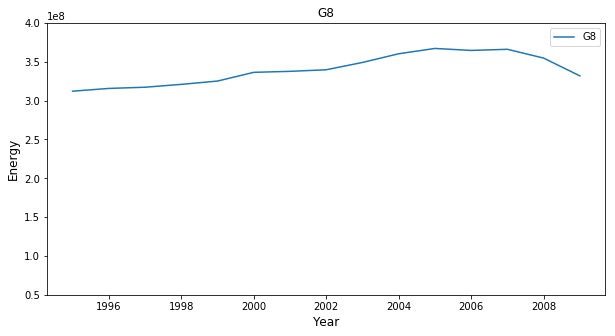

In [21]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

G8_cons_nrg.plot(ax=ax, x='Year', y='G8')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Energy', fontsize=12)
ax.set_ylim([50000000, 400000000])
ax.set_title('G8')

### 6.2. What proportion of the UK energy footprint is sourced from G8 nations?

Using aggregate matrices

In [22]:
G8 = ['CAN','DEU','FRA','GBR','ITA','JPN','RUS','USA']
country = Y[0].columns.levels[0].tolist()
regions = len(country)
sectors = len(Z[0].columns.levels[1].tolist())

G8_lookup = np.zeros((regions,1))
G8_F_agg = np.zeros((1,regions*sectors))

for i in range(len(country)):
    if country[i] in G8:
        G8_lookup[i] = 1
        
for i in range(len(G8_lookup)):
    j = i+1 # because indexing starts at 0 in python
    if G8_lookup[i] == 1:
        G8_F_agg[0][(j*sectors)-sectors:j*sectors] = np.ones((sectors,1)).reshape(1, sectors)[0]

In [23]:
UK_G8_prop = []

for i in range(len(year_list)):
    x = np.array(Y[i].sum(axis=1) + Z[i].sum(axis=1))
    for j in range(len(x)):
        if x[j]==0:
            x[j]=0.000000001 # do this to avoid trying to divide my zero later
        else:
            pass
    x = x.reshape(1435,1)
    big_x = x.repeat(len(x), axis=1)
    x_t = np.matrix.transpose(big_x)
    
    A = np.array(Z[i]) / x_t
    I = np.identity(len(Z[i]))
    L = np.linalg.inv(I-A)
    
    Y_UK = np.array(Y[i][['GBR']]).sum(axis=1).reshape(1435, 1)
    
    # UK energy footprint
    F_NRGx = np.array(F_NRG[i]) / (x.reshape(1, 1435))  
    temp = np.matmul(F_NRGx, L)
    temp = np.matmul(temp, Y_UK)
    UK_cons = temp + float(F_NRG_hh[i]['GBR'])
    
    # from G8
    F_G8 = G8_F_agg * np.array(F_NRG[i])
    F_G8x = F_G8 / (x.reshape(1, 1435))
    temp = np.matmul(F_G8x, L)
    temp = np.matmul(temp, Y_UK)
    
    a = temp[0][0] / UK_cons[0][0] * 100
    
    UK_G8_prop.append(a)

Text(0.5,1,'UK NRG - G8 Proportion')

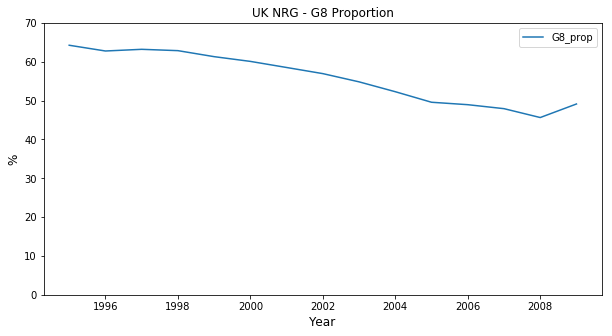

In [24]:
UK_G8_prop_df = pd.DataFrame()
UK_G8_prop_df['G8_prop'] = UK_G8_prop
UK_G8_prop_df['Year'] = year_list

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

UK_G8_prop_df.plot(ax=ax, x='Year', y='G8_prop')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('%', fontsize=12)
ax.set_ylim([0,70])
ax.set_title('UK NRG - G8 Proportion')

### 6.3. Making a smaller version of the WIOD matrix using aggregation matrices

In [25]:
G8 = ['CAN','DEU','FRA','GBR','ITA','JPN','RUS','USA']
country = Y[0].columns.levels[0].tolist()
regions = len(country)
sectors = len(Z[0].columns.levels[1].tolist())
final_demand = len(Y[1].columns.levels[1].tolist())

G8_lookup = np.zeros((regions, 1))
G8_agg = np.zeros((2*sectors, regions*sectors))
G8_Y_agg = np.zeros((2*final_demand, final_demand*regions))
    
for i in range(len(country)):
    if country[i] in G8:
        G8_lookup[i] = 1
        
for i in range(len(G8_lookup)):
    j = i+1 # because indexing starts at 0 in python
    if G8_lookup[i] == 1:
        G8_agg[0:sectors, j*sectors-(sectors):j*sectors] = np.identity(sectors)
        G8_Y_agg[0:final_demand, j*final_demand-(final_demand):j*final_demand] = np.identity(final_demand)
        
    else:
        G8_agg[sectors:2*sectors, j*sectors-(sectors):j*sectors] = np.identity(sectors)
        G8_Y_agg[final_demand:2*final_demand, j*final_demand-(final_demand):j*final_demand] = np.identity(final_demand)
        
G8_Y_agg = np.matrix.transpose(G8_Y_agg)

In [26]:
G8_energy_cons_agg = []
new_Z_list = []
new_F_list = []
new_Y_list = []

for i in range(len(year_list)):
    C_t = np.matrix.transpose(G8_agg)
    new_Z = np.matmul(np.matmul(G8_agg, Z[i]), C_t)
    new_F = np.matmul(np.array(F_NRG[i]), C_t)
    new_Y = np.matmul(np.matmul(G8_agg, Y[i]), G8_Y_agg)
    
    new_Z_list.append(new_Z)
    new_F_list.append(new_F)
    new_Y_list.append(new_Y)
    
    x = np.array(new_Y.sum(axis=1) + new_Z.sum(axis=1))
    for j in range(len(x)):
        if x[j]==0:
            x[j]=0.000000001 # do this to avoid trying to divide my zero later
        else:
            pass
    x = x.reshape(70, 1)
    big_x = x.repeat(len(x), axis=1)
    x_t = np.matrix.transpose(big_x)
    
    A = np.array(new_Z) / x_t
    I = np.identity(len(new_Z))
    L = np.linalg.inv(I-A)
    
    Y_G8 = np.array(new_Y[:, :5]).sum(axis=1)
    Y_G8 = Y_G8.reshape(Y_G8.shape[0], 1)
    
    # G8 energy footprint
    F_NRGx = new_F / np.matrix.transpose(x)
    temp = np.matmul(F_NRGx, L)
    temp = np.matmul(temp, Y_G8)
    G8_cons = temp + float(F_NRG_hh[i][G8].sum(axis=1))
    
    G8_energy_cons_agg.append(G8_cons[0][0])

Text(0.5,1,'UK NRG - G8 Proportion')

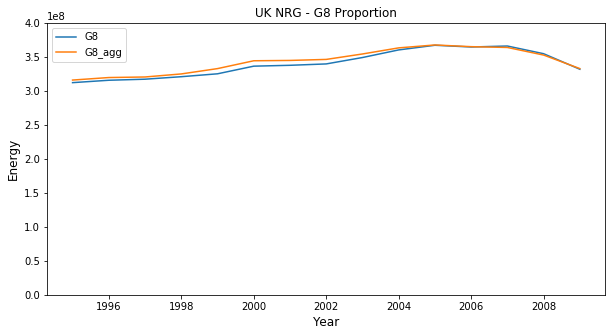

In [27]:
G8_cons_nrg['G8_agg'] = G8_energy_cons_agg

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

G8_cons_nrg.plot(ax=ax, x='Year', y='G8')
G8_cons_nrg.plot(ax=ax, x='Year', y='G8_agg')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Energy', fontsize=12)
ax.set_ylim([0, 400000000])
ax.set_title('UK NRG - G8 Proportion')

### 6.4. Making an even smaller version of the WIOD matrix

In [28]:
file_loc = 'Data/WIOT/wiot' + str(1995)[2:] + '_row_apr12.xlsx'
    
# import data
df = pd.read_excel(file_loc, index_col=None, header=None).iloc[2:6].T
df = df.loc[df[4] == 'AUS']
df[4] = df[5]
df.loc[df[5].map(str).apply(len) == 2, 4] = 'c0' + df[5].str[-1]
df[2] = df[2].astype(str)

In [29]:
extraction_from_nature = ['AtB', 'C']
manufacturing = ['15t16', '17t18', '19', '20', '21t22', '23', '24', '25', '26', '27t28', '29', '30t33', '34t35', '36t37']
fuel = ['E']
construction = ['F']
trade = ['50', '51', '52', 'H']
transport = ['60', '61', '62']
private_services = ['J', '70', '71t74']
public_services_other = ['L', 'M', 'N', 'O', 'P']

new_sectors = [extraction_from_nature, manufacturing, fuel, construction, trade, transport, private_services, public_services_other]

In [30]:
dictionary = dict(zip(df[2].tolist(), df[4].tolist()))   

for sector in new_sectors:
    for i in range(len(sector)):
        sector[i] = dictionary[sector[i]]

In [31]:
#### make aggreagtion matrix for new secotrs

region_names = ['G8', 'ROW']
regions = len(region_names)
old_sector_no = int(new_Z_list[0].shape[0] / regions)
new_sector_no = len(new_sectors)
sectors = df[5].tolist()

sector_agg = np.zeros((new_sector_no * regions, old_sector_no * regions))
sector_lookup = np.zeros((new_sector_no, old_sector_no))

k=0
for i in range(len(new_sectors)):
    sector_lookup[i, k:k+len(new_sectors[i])] = np.ones((1, len(new_sectors[i])))
    k += len(new_sectors[i])

sector_agg[:sector_lookup.shape[0], :sector_lookup.shape[1]] = sector_lookup
sector_agg[sector_lookup.shape[0]:, sector_lookup.shape[1]:] = sector_lookup

Text(0.5,1,'UK NRG - G8 Proportion')

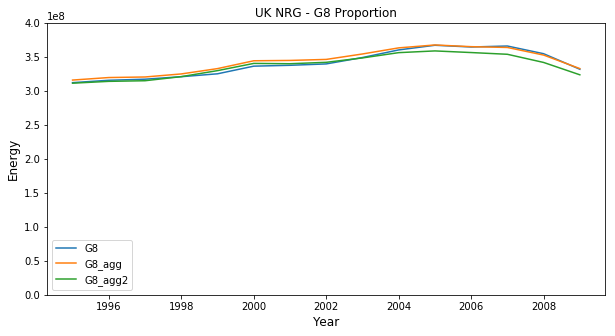

In [37]:
# using previous answer
G8_energy_cons_agg2 = []

for i in range(len(year_list)):
    C_t = np.matrix.transpose(sector_agg)
    new_Z = np.matmul(np.matmul(sector_agg, new_Z_list[i]), C_t)
    new_F = np.matmul(new_F_list[i], C_t)
    new_Y = np.matmul(sector_agg, new_Y_list[i])
    
    x = np.array(new_Y.sum(axis=1) + new_Z.sum(axis=1))
    for j in range(len(x)):
        if x[j]==0:
            x[j]=0.000000001 # do this to avoid trying to divide my zero later
        else:
            pass
    x = x.reshape(x.shape[0], 1)
    big_x = x.repeat(len(x), axis=1)
    x_t = np.matrix.transpose(big_x)
    
    A = np.array(new_Z) / x_t
    I = np.identity(len(new_Z))
    L = np.linalg.inv(I-A)
    
    Y_G8 = np.array(new_Y[:, :5]).sum(axis=1)
    Y_G8 = Y_G8.reshape(Y_G8.shape[0], 1)
    
    # G8 energy footprint
    F_NRGx = new_F / np.matrix.transpose(x)  
    temp = np.matmul(F_NRGx, L)
    temp = np.matmul(temp, Y_G8)
    G8_cons = temp + float(F_NRG_hh[i][G8].sum(axis=1))
    
    G8_energy_cons_agg2.append(G8_cons[0][0])

# plot answer
G8_cons_nrg['G8_agg2'] = G8_energy_cons_agg2

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

G8_cons_nrg.plot(ax=ax, x='Year', y='G8')
G8_cons_nrg.plot(ax=ax, x='Year', y='G8_agg')
G8_cons_nrg.plot(ax=ax, x='Year', y='G8_agg2')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Energy', fontsize=12)
ax.set_ylim([0, 400000000])
ax.set_title('UK NRG - G8 Proportion')

In [38]:
# starting from original Z, Y and F 

# make aggregate matrices
G8 = ['CAN','DEU','FRA','GBR','ITA','JPN','RUS','USA']
country = Y[0].columns.levels[0].tolist()
regions = len(country)
sectors = len(Z[0].columns.levels[1].tolist())
final_demand = len(Y[1].columns.levels[1].tolist())

sectoragg = np.matrix.transpose(sector_lookup)

G8_agg = np.zeros((2*8, regions*sectors))
G8_reg_agg = np.zeros((regions*final_demand, 2))

for m in range(regions):
    j = m+1
    if G8_lookup[m][0] == 1:
        G8_agg[:8, j*sectors-sectors:j*sectors] = sector_lookup
        G8_reg_agg[j*final_demand-final_demand:j*final_demand, :1] = np.ones((final_demand, 1))
    else:
        G8_agg[8:, j*sectors-sectors:j*sectors] = sector_lookup
        G8_reg_agg[j*final_demand-final_demand:j*final_demand, 1:] = np.ones((final_demand, 1))
        
#Run analysis
G8_nrg_cons_agg3 = []

G8_agg_t = np.matrix.transpose(G8_agg)
for i in range(len(year_list)):
    Zagg = np.matmul(np.matmul(G8_agg, Z[i]), G8_agg_t)
    Yagg = np.matmul(np.matmul(G8_agg, Y[i]), G8_reg_agg)
    F_NRGagg = np.matmul(F_NRG[i], G8_agg_t)
    
    x = Zagg.sum(axis=1) + Yagg.sum(axis=1)
    for j in range(len(x)):
        if x[j]==0:
            x[j]=0.000000001 # do this to avoid trying to divide my zero later
        else:
            pass
    x = x.reshape(x.shape[0], 1)
    big_x = x.repeat(len(x), axis=1)
    x_t = np.matrix.transpose(big_x) 
    
    A = np.array(Zagg) / x_t
    I = np.identity(Zagg.shape[0])
    L = np.linalg.inv(I-A)
    
    # G8 energy footprint   
    F_NRGx = F_NRGagg / np.matrix.transpose(x)
    G8_cons = np.matmul(np.matmul(F_NRGx, L), Yagg[:, :1]) + float(F_NRG_hh[i][G8].sum(axis=1))
    
    G8_nrg_cons_agg3.append(G8_cons[0][0])

Text(0.5,1,'UK NRG - G8 Proportion')

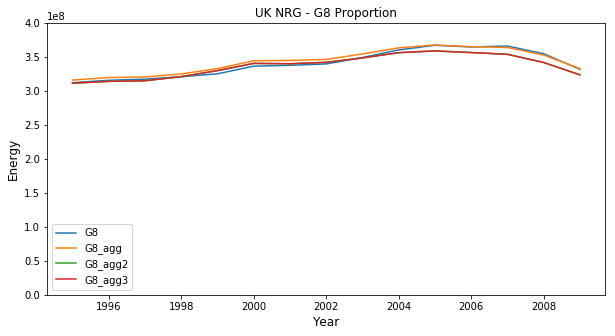

In [39]:
G8_cons_nrg['G8_agg3'] = G8_nrg_cons_agg3

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

G8_cons_nrg.plot(ax=ax, x='Year', y='G8')
G8_cons_nrg.plot(ax=ax, x='Year', y='G8_agg')
G8_cons_nrg.plot(ax=ax, x='Year', y='G8_agg2')
G8_cons_nrg.plot(ax=ax, x='Year', y='G8_agg3')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Energy', fontsize=12)
ax.set_ylim([0, 400000000])
ax.set_title('UK NRG - G8 Proportion')

## 7. Working with expenditure survey data
### 7.1. The GHG footprint of men and women in the UK

In [84]:
expenditure = pd.read_csv('Data/Q7.csv').set_index('Unnamed: 0')
expenditure.head()

,Average yearly spend by a man (USD),Average yearly spend by a woman (USD)
Unnamed: 0,,
"Agriculture, Hunting, Forestry and Fishing",400,430
Mining and Quarrying,30,25
"Food, Beverages and Tobacco",1000,1300
Textiles and Textile Products,400,350
"Leather, Leather and Footwear",60,100


### How can you use this (expenditure infromation from 2009) to find the share of the UK’s household GHG footprint by men and women?

In [199]:
# 1. Check whether the spend for all men plus the spend for all women is equal to the data held in WIOD. Do this by calculating the spend by sector by UK households regardless of where the goods are from.
# In the UK in 2009 there were 30 million men and 33 million women

expenditure['Total_Men'] = expenditure['Average yearly spend by a man (USD)'] * 30
expenditure['Total_Women'] = expenditure['Average yearly spend by a woman (USD)'] * 33

# difference 
expenditure['Total_All'] = expenditure[['Total_Men', 'Total_Women']].sum(axis=1).tolist()
expenditure['WIOT'] = Y[-1][[('GBR', 'c37')]].unstack().T.sum(axis=1).tolist()

expenditure['Difference'] = expenditure['Total_All'] - expenditure['WIOT']

expenditure.index = Y[-1].index.levels[1]
expenditure[['Total_All', 'WIOT', 'Difference']].head() # can see individual sector differences here (all in million USD)

,Total_All,WIOT,Difference
"(nan, 'sector')",,,
c01,26190,25942.298041,247.701959
c02,1725,1576.326374,148.673626
c03,72900,69832.031753,3067.968247
c04,23550,24807.434198,-1257.434198
c05,5100,4066.328518,1033.671482


In [102]:
expenditure[['Total_All', 'WIOT', 'Difference']].sum(axis=0)

Total_All     1.318395e+06
WIOT          1.262979e+06
Difference    5.541642e+04
dtype: float64

In [200]:
# 2. What are you going to do if the spends are different? Which data do you trust? We want the footprint of men + women to be equal to the footprint of UK households calculated in WIOD so it 
# makes sense to trust the WIOD totals.

# go around this by splitting WIOT into men and women --> calculate spend proportion
expenditure['Prop_Men'] = expenditure['Total_Men'] / expenditure['Total_All']
expenditure['Prop_Women'] = expenditure['Total_Women'] / expenditure['Total_All']

expenditure.head()

,Average yearly spend by a man (USD),Average yearly spend by a woman (USD),Total_Men,Total_Women,Total_All,WIOT,Difference,Prop_Men,Prop_Women
"(nan, 'sector')",,,,,,,,,
c01,400,430,12000,14190,26190,25942.298041,247.701959,0.458190,0.541810
c02,30,25,900,825,1725,1576.326374,148.673626,0.521739,0.478261
c03,1000,1300,30000,42900,72900,69832.031753,3067.968247,0.411523,0.588477
c04,400,350,12000,11550,23550,24807.434198,-1257.434198,0.509554,0.490446
c05,60,100,1800,3300,5100,4066.328518,1033.671482,0.352941,0.647059


In [201]:
i=0
women_list = []
men_list = []
while i < len(country):
    women_list += expenditure['Prop_Women'].tolist()
    men_list += expenditure['Prop_Men'].tolist()
    i+=1

In [202]:
# 3. Make a new final demand matrix with two columns for UK men and UK women to find the footprint of each. The matrix needs to be 1435 x 2 in dimension. What assumptions will you make 
# as to where men and women buy items from?

# --> assume that proportions by sector are equal across regions

new_Y = Y[-1][[('GBR', 'c37')]] 
new_Y['Prop_Women'], new_Y['Prop_Men'] = women_list, men_list
new_Y['Prop_Women'], new_Y['Prop_Men'] = new_Y['Prop_Women']*new_Y[('GBR', 'c37')], new_Y['Prop_Men']*new_Y[('GBR', 'c37')]
new_Y[['Prop_Women', 'Prop_Men']].head()

c:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
c:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Prop_Women    Prop_Men
                                                          
('country', 'TOT') (nan, 'sector')                        
AUS                c01                8.929644    7.551496
                   c02                0.239062    0.260795
                   c03              339.356696  237.312375
                   c04               37.472666   38.932640
                   c05               15.234198    8.309562

In [229]:
# 4. How are you going to share out the direct emissions?

x = np.array(Y[-1].sum(axis=1) + Z[-1].sum(axis=1))
for j in range(len(x)):
    if x[j]==0:
        x[j]=0.000000001 # do this to avoid trying to divide my zero later
x = x.reshape(1435,1)
big_x = x.repeat(len(x), axis=1)
x_t = np.matrix.transpose(big_x)
    
A = np.array(Z[-1]) / x_t
I = np.identity(len(Z[-1]))
L = np.linalg.inv(I-A)
F_GHGx = np.array(F_GHG[-1]) / (x.reshape(1, 1435))
    
Y_women = np.array(new_Y['Prop_Women']).reshape(1435, 1)
Y_men = np.array(new_Y['Prop_Men']).reshape(1435, 1)

F_hh_women = ((expenditure.loc['c17', 'Average yearly spend by a woman (USD)'] + 
               expenditure.loc['c19', 'Average yearly spend by a woman (USD)']) * 33) / (
    (expenditure.loc['c17', ['Average yearly spend by a man (USD)', 'Average yearly spend by a woman (USD)']].sum() +
     expenditure.loc['c19', ['Average yearly spend by a man (USD)', 'Average yearly spend by a woman (USD)']].sum()) * 33)
F_hh_men = 1- F_hh_women

women_2009 = np.matmul(np.matmul(F_GHGx, L), Y_women)[0][0] + (float(F_GHG_hh[-1]['GBR']) * F_hh_women)
    
men_2009 = np.matmul(np.matmul(F_GHGx, L), Y_men)[0][0] + (float(F_GHG_hh[-1]['GBR']) * F_hh_men)

Text(0.5,1,'UK 2009 GHG Emissions Split by Gender')

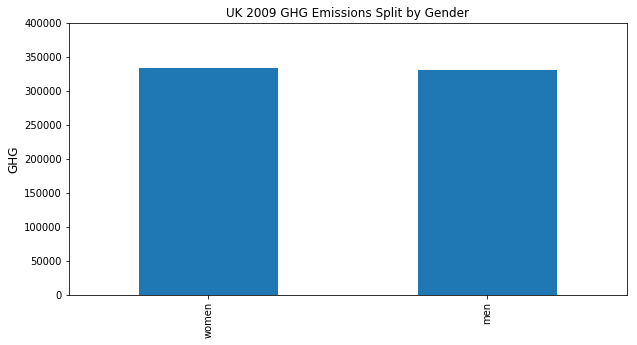

In [264]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

pd.DataFrame([women_2009, men_2009], ['women', 'men']).plot.bar(ax=ax, legend=False)
ax.set_ylabel('GHG', fontsize=12)
ax.set_ylim([0, 400000])
ax.set_title('UK 2009 GHG Emissions Split by Gender')

### 7.2. The GHG footprint of devolved nations in the UK
For this exercise try to disaggregate the spends – what could you use to split the spends out into the full categories?
If the populations are:  
•	England 47 million  
•	Wales 3 million  
•	Northern Ireland 3 million  
•	Scotland 10 million 
  
Which country has the largest per capita footprint?

In [476]:
UK_countries = ['England', 'Wales', 'Northern Ireland', 'Scotland']
populations = [47, 3, 3, 10]
new_sectors_2 = ['extraction_from_nature', 'manufacturing', 'fuel', 'construction', 'trade', 'transport', 'private_services', 'public_services_other']

nations = pd.read_csv('Data/Q7-2.csv').set_index('Unnamed: 0')

for i in range(len(UK_countries)):
    nations[str(UK_countries[i]) + ' total spend (millions USD)'] = nations[str(UK_countries[i]) + ' total spend (millions USD)'].str.replace(',', '').astype(int)
    nations[str(UK_countries[i]) + '_percap'] = nations[str(UK_countries[i]) + ' total spend (millions USD)'] / populations[i]

nations.index = new_sectors_2

nations

# These spends include the government, capital, etc expenditures

,England total spend (millions USD),Wales total spend (millions USD),Northern Ireland total spend (millions USD),Scotland total spend (millions USD),England_percap,Wales_percap,Northern Ireland_percap,Scotland_percap
extraction_from_nature,20000000,1000000,2000000,7000000,4.255319e+05,3.333333e+05,6.666667e+05,700000.0
manufacturing,290000000,4000000,5000000,30000000,6.170213e+06,1.333333e+06,1.666667e+06,3000000.0
fuel,40000000,2000000,3000000,10000000,8.510638e+05,6.666667e+05,1.000000e+06,1000000.0
construction,120000000,5000000,5000000,40000000,2.553191e+06,1.666667e+06,1.666667e+06,4000000.0
trade,290000000,10000000,8000000,50000000,6.170213e+06,3.333333e+06,2.666667e+06,5000000.0
transport,70000000,5000000,4000000,10000000,1.489362e+06,1.666667e+06,1.333333e+06,1000000.0
private_services,300000000,20000000,15000000,60000000,6.382979e+06,6.666667e+06,5.000000e+06,6000000.0
public_services_other,650000000,30000000,25000000,40000000,1.382979e+07,1.000000e+07,8.333333e+06,4000000.0


In [499]:
UK_countries = ['England', 'Wales', 'Northern Ireland', 'Scotland']
populations = [47, 3, 3, 10]
new_sectors_2 = ['extraction_from_nature', 'manufacturing', 'fuel', 'construction', 'trade', 'transport', 'private_services', 'public_services_other']

nations = pd.read_csv('Data/Q7-2.csv').set_index('Unnamed: 0')

for i in range(len(UK_countries)):
    nations[str(UK_countries[i]) + ' total spend (millions USD)'] = nations[str(UK_countries[i]) + ' total spend (millions USD)'].str.replace(',', '').astype(int)
    nations[str(UK_countries[i]) + '_percap'] = nations[str(UK_countries[i]) + ' total spend (millions USD)'] / populations[i]

nations.index = new_sectors_2

sector_big = []
sector_small = []

for i in range(len(new_sectors)):
    sector_small += new_sectors[i]
    for j in range(len(new_sectors[i])):
        a = new_sectors_2[i]
        sector_big.append(a)
sector_big += ['c26', 'c27']
sector_small += ['c26', 'c27']

new_Y = Y[-1]['GBR'].reset_index().groupby("(nan, 'sector')").sum(axis=1).drop("('country', 'TOT')", axis=1)
c_save = new_Y.loc['c26':'c27', 'c39']

new_Y = new_Y.join(pd.DataFrame(sector_big, sector_small))

new_Y = new_Y.reset_index().merge(new_Y.groupby(0).sum(axis=1).reset_index(), on=0, how='left')
 
for i in [37, 38, 39, 41, 42]:
    new_Y['c'+str(i)+'_prop'] = new_Y['c'+str(i)+'_x'] / new_Y['c'+str(i)+'_y']

    
new_Y = new_Y[[0, "(nan, 'sector')", 'c37_prop', 'c38_prop', 'c39_prop', 'c41_prop', 'c42_prop']]

cols = [] 
nations = nations.reset_index().rename(columns={'index':0})
final = new_Y.merge(nations, on=0, how='left').set_index([0, "(nan, 'sector')"])
for country in UK_countries:
    for i in [39]:  # [37, 38, 39, 41, 42]
        new_col = country + '_c' + str(i)
        final[new_col] = final[country + ' total spend (millions USD)'] * final['c'+str(i)+'_prop']
        cols.append(new_col)
        
final = final[cols]
final.head()

England_c39      Wales_c39  \
0                      (nan, 'sector')                                
extraction_from_nature c01              1.999954e+07  999977.190391   
                       c02              4.561922e+02      22.809609   
manufacturing          c03              3.171189e+06   43740.533982   
                       c04              1.969158e+06   27160.800423   
                       c05              8.084784e+03     111.514268   

                                        Northern Ireland_c39  Scotland_c39  
0                      (nan, 'sector')                                      
extraction_from_nature c01                      1.999954e+06  6.999840e+06  
                       c02                      4.561922e+01  1.596673e+02  
manufacturing          c03                      5.467567e+04  3.280540e+05  
                       c04                      3.395100e+04  2.037060e+05  
                       c05                      1.393928e+02  8.363570e+02

In [501]:
nations

,0,England total spend (millions USD),Wales total spend (millions USD),Northern Ireland total spend (millions USD),Scotland total spend (millions USD),England_percap,Wales_percap,Northern Ireland_percap,Scotland_percap
0,extraction_from_nature,20000000,1000000,2000000,7000000,4.255319e+05,3.333333e+05,6.666667e+05,700000.0
1,manufacturing,290000000,4000000,5000000,30000000,6.170213e+06,1.333333e+06,1.666667e+06,3000000.0
2,fuel,40000000,2000000,3000000,10000000,8.510638e+05,6.666667e+05,1.000000e+06,1000000.0
3,construction,120000000,5000000,5000000,40000000,2.553191e+06,1.666667e+06,1.666667e+06,4000000.0
4,trade,290000000,10000000,8000000,50000000,6.170213e+06,3.333333e+06,2.666667e+06,5000000.0
5,transport,70000000,5000000,4000000,10000000,1.489362e+06,1.666667e+06,1.333333e+06,1000000.0
6,private_services,300000000,20000000,15000000,60000000,6.382979e+06,6.666667e+06,5.000000e+06,6000000.0
7,public_services_other,650000000,30000000,25000000,40000000,1.382979e+07,1.000000e+07,8.333333e+06,4000000.0


In [541]:
# from Matlab

spend = pd.read_csv('Data/Q7-2.csv').set_index('Unnamed: 0')
for i in range(len(UK_countries)):
    spend[str(UK_countries[i]) + ' total spend (millions USD)'] = spend[str(UK_countries[i]) + ' total spend (millions USD)'].str.replace(',', '').astype(int)

spend['total'] = spend.sum(axis=1)
spend.iloc[:,:-1].div(spend.total, axis=0)

spend

,England total spend (millions USD),Wales total spend (millions USD),Northern Ireland total spend (millions USD),Scotland total spend (millions USD),total
Unnamed: 0,,,,,
Extraction from nature,20000000,1000000,2000000,7000000,30000000
Manufacturing,290000000,4000000,5000000,30000000,329000000
Fuel,40000000,2000000,3000000,10000000,55000000
Construction,120000000,5000000,5000000,40000000,170000000
Trade,290000000,10000000,8000000,50000000,358000000
Transport,70000000,5000000,4000000,10000000,89000000
Private services,300000000,20000000,15000000,60000000,395000000
Public services & other,650000000,30000000,25000000,40000000,745000000


In [617]:
UKspendbysector = np.zeros((sectors,1))
UKspendbyregprop = np.zeros((sectors*regions,1))

for i in range(regions):
    a=i+1
    temp = np.array(Y[-1]['GBR'])[a*sectors-35:a*sectors].sum(1)
    temp = temp.reshape(temp.shape[0], 1)
    UKspendbysector[:,:] += temp
    
for i in range(regions):
    a=i+1
    temp = np.array(Y[-1]['GBR'])[a*sectors-35:a*sectors].sum(1)
    temp = temp.reshape(temp.shape[0], 1)
    UKspendbyregprop[a*sectors-35:a*sectors,:] = temp / UKspendbysector

In [ ]:
# do this tomorrow!!!!

UKspendbydev_short = sectoragg*spendprop.*repmat(UKspendbysector,1,4);

UKspendbydev_long = repmat(UKspendbydev_short,regions,1).*repmat(UKhhspendbyregprop,1,4);

In [ ]:
spend = xlsread('WIOD_Exercises_Data.xlsx','Additional data','C39:F46');
spendprop = spend./repmat(sum(spend,2),1,4); 

UKspendbysector = zeros(sectors,1);
UKspendbyregprop = zeros(sectors*regions,1);

for a = 1:regions
    temp = sum(Y(a*sectors-34:a*sectors,(UK*final_demand)-4:UK*final_demand,15),2);
    UKspendbysector(1:sectors,:) = UKspendbysector(1:sectors)+temp;
end
for a = 1:regions
    UKspendbyregprop(a*sectors-34:a*sectors,1)=sum(Y(a*sectors-34:a*sectors,(UK*final_demand)-4:UK*final_demand,15),2)./UKspendbysector;
end
UKspendbydev_short = sectoragg*spendprop.*repmat(UKspendbysector,1,4);

UKspendbydev_long = repmat(UKspendbydev_short,regions,1).*repmat(UKhhspendbyregprop,1,4);

UKconsGHG_dev(1,1) = (F_GHGx*L*UKspendbydev_long(:,1))+(F_GHG_hh(:,UK,15)*(spend(3,1))/(sum(spend(3,:),2))); 
UKconsGHG_dev(1,2) = (F_GHGx*L*UKspendbydev_long(:,2))+(F_GHG_hh(:,UK,15)*(spend(3,2))/(sum(spend(3,:),2))); 
UKconsGHG_dev(1,3) = (F_GHGx*L*UKspendbydev_long(:,3))+(F_GHG_hh(:,UK,15)*(spend(3,3))/(sum(spend(3,:),2))); 
UKconsGHG_dev(1,4) = (F_GHGx*L*UKspendbydev_long(:,4))+(F_GHG_hh(:,UK,15)*(spend(3,4))/(sum(spend(3,:),2))); 
